This notebook includes segmentation results from nucleus mask and DR calculation. With this subcellular segmentation, reads fraction are calculated, with all genes and genes in defined clusters.

In [2]:
import scanpy as sc
import os
from spatial_funcs import *
from scipy.stats import kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Data

In [2]:
fpath = '/stanley/WangLab/Data/Analyzed/2021-07-16-Rena-Hela-EU'
sample_list = ['1h_labeling', '1h_labeling_1h_wash', '1h_labeling_2h_wash', '1h_labeling_4h_wash', '1h_labeling_6h_wash', '20h_labeling']
adata_all = sc.read_h5ad(os.path.join(fpath, 'output', '2021-10-06-Rena-EU-starmap-cc.h5ad'))
genes = adata_all.var.index
genesToIndex = genes_to_index(genes)
starmap_genes = ['METTL14', 'METTL3', 'YTHDC2', 'YTHDF1', 'YTHDF2', 'YTHDF3', 'YTHDC1'] 

In [3]:
gene_label = pd.read_csv('/stanley/WangLab/Connie/tempo_/gene_label.csv')
gene_label

,Unnamed: 0,gene,cluster
0,1,AARS,2
1,2,ASXL1,1
2,3,COX7B,3
3,4,CTGF,2
4,5,DLX4,2
...,...,...,...
803,804,ZRANB1,1
804,805,ZSCAN12,2
805,806,ZSCAN29,2
806,807,ZXDC,1


In [4]:
c1 = gene_label.loc[gene_label['cluster']==0, 'gene'].values
c2 = gene_label.loc[gene_label['cluster']==1, 'gene'].values
c3 = gene_label.loc[gene_label['cluster']==2, 'gene'].values
c4 = gene_label.loc[gene_label['cluster']==3, 'gene'].values

# Result

### all genes

In [5]:
drPath = '/stanley/WangLab/Connie/tempo_/DR1'
adata_DRP = dict() 
for sample in sample_list:
    adata = separate_adata_by_sample(adata_all, [sample], adata_layers=['cytoplasm', 'nucleus'])
    dr = np.load(os.path.join(drPath, sample+'_DR.npy'), allow_pickle=True)
    drp_10p = np.zeros(dr.shape)
    drp_10q = np.zeros(dr.shape)
    for i in range(dr.shape[0]):
        for j in range(dr.shape[1]): # dr contains only cyto reads (0 if no reads, [] of DR if reads)
            if type(dr[i,j]) == list:
                drp_10p[i,j] = np.count_nonzero(np.array(dr[i,j])<0.909)
                drp_10q[i,j] = np.count_nonzero(np.array(dr[i,j])>=0.909)
    adata.layers['drp_10p'] = drp_10p
    adata.layers['drp_10q'] = drp_10q
    adata_DRP[sample] = adata

In [6]:
cell_label = pd.read_csv('/stanley/WangLab/Connie/tempo_/Jan21_new_label.csv')
for sample in sample_list[:5]:
    adata_DRP[sample].obs['KD_label_new'] = cell_label[cell_label['sample']==sample]['KD_label_new'].to_list()

In [7]:
bulk = dict() # remove both KD cells and starmap genes
for sample in sample_list[:5]:
    bulk[sample] = dict()
    nuc = np.expand_dims(np.sum(adata_DRP[sample].layers['nucleus'][:,np.isin(genes, starmap_genes, invert=True)], axis=1), axis=1)
    mid = np.expand_dims(np.sum(adata_DRP[sample].layers['drp_10p'][:,np.isin(genes, starmap_genes, invert=True)], axis=1), axis=1)
    peri = np.expand_dims(np.sum(adata_DRP[sample].layers['drp_10q'][:,np.isin(genes, starmap_genes, invert=True)], axis=1), axis=1)
    reg = np.concatenate((nuc, mid, peri), axis=1)
    reg = reg[adata_DRP[sample].obs['KD_label_new']=='siControl']
    reg_norm = np.array([row/sum(row) for row in reg])
    bulk[sample]['mean'] = np.mean(reg_norm, axis=0) # mean or median
    bulk[sample]['std'] = np.std(reg_norm, axis=0)

Text(0.5, 1.0, 'All genes')

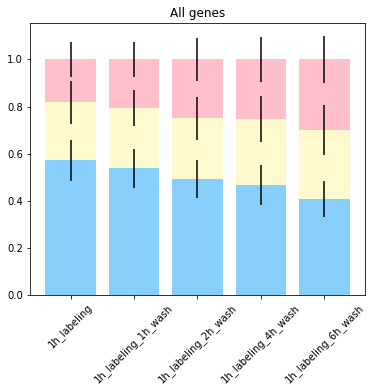

In [8]:
nuc_mean, mid_mean, peri_mean = [bulk[sample]['mean'][0] for sample in sample_list[:5]], [bulk[sample]['mean'][1] for sample in sample_list[:5]], [bulk[sample]['mean'][2] for sample in sample_list[:5]]
nuc_std, mid_std, peri_std = [bulk[sample]['std'][0] for sample in sample_list[:5]], [bulk[sample]['std'][1] for sample in sample_list[:5]], [bulk[sample]['std'][2] for sample in sample_list[:5]]
fig, ax = plt.subplots(figsize=(6,5))
ax.bar(sample_list[:5], nuc_mean, yerr=nuc_std, label='nuc', color='lightskyblue')
ax.bar(sample_list[:5], mid_mean, yerr=mid_std, bottom=nuc_mean, label='mid', color='lemonchiffon')
ax.bar(sample_list[:5], peri_mean, yerr=peri_std, bottom=np.sum((nuc_mean, mid_mean), axis=0), label='peri', color='pink')
plt.xticks(rotation=45)
plt.title('All genes')

### by cluster

cluster_0 statistic tests ------ 
KruskalResult(statistic=1220.0389578982836, pvalue=7.210435469025845e-263)
             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
       group1              group2       meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------------------
        1h_labeling 1h_labeling_1h_wash  -0.0279   0.0 -0.0384 -0.0174   True
        1h_labeling 1h_labeling_2h_wash  -0.0722   0.0 -0.0832 -0.0611   True
        1h_labeling 1h_labeling_4h_wash  -0.0942   0.0 -0.1051 -0.0832   True
        1h_labeling 1h_labeling_6h_wash  -0.1541   0.0 -0.1671 -0.1412   True
1h_labeling_1h_wash 1h_labeling_2h_wash  -0.0442   0.0 -0.0551 -0.0334   True
1h_labeling_1h_wash 1h_labeling_4h_wash  -0.0662   0.0  -0.077 -0.0555   True
1h_labeling_1h_wash 1h_labeling_6h_wash  -0.1262   0.0 -0.1389 -0.1135   True
1h_labeling_2h_wash 1h_labeling_4h_wash   -0.022   0.0 -0.0333 -0.0107   True
1h_labeling_2h_wash 1h_labeling_6

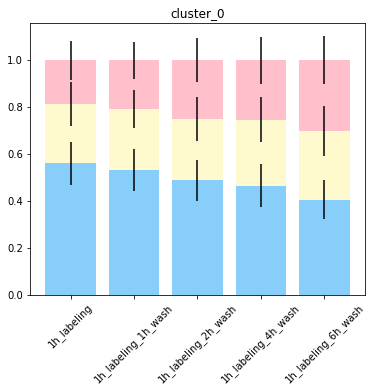

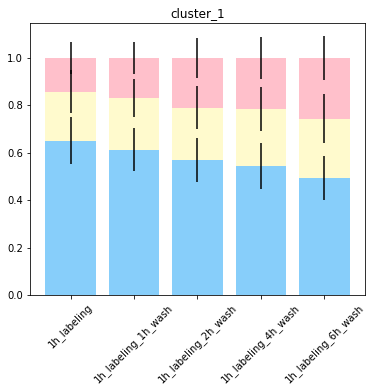

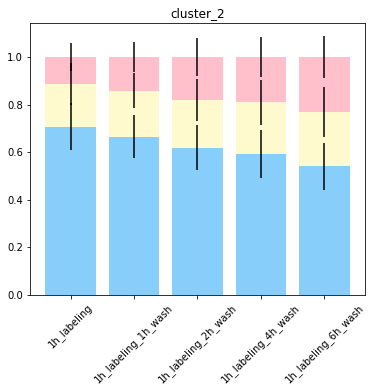

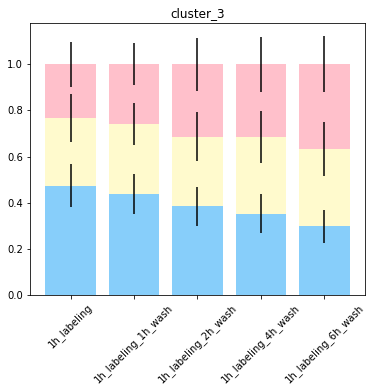

In [9]:
for i, gene_cluster in enumerate([c1,c2,c3,c4]):
    bulk = dict() 
    nuc_pct = dict()    # for stats purposes
    for sample in sample_list[:5]:
        bulk[sample] = dict()
        nuc = np.expand_dims(np.sum(adata_DRP[sample].layers['nucleus'][:,np.isin(genes, gene_cluster)], axis=1), axis=1)
        mid = np.expand_dims(np.sum(adata_DRP[sample].layers['drp_10p'][:,np.isin(genes, gene_cluster)], axis=1), axis=1)
        peri = np.expand_dims(np.sum(adata_DRP[sample].layers['drp_10q'][:,np.isin(genes, gene_cluster)], axis=1), axis=1)
        reg = np.concatenate((nuc, mid, peri), axis=1)
        reg = reg[adata_DRP[sample].obs['KD_label_new']=='siControl']
        reg_norm = np.array([row/sum(row) for row in reg])
        nuc_pct[sample] = reg_norm[:,0]
        bulk[sample]['mean'] = np.mean(reg_norm, axis=0)
        bulk[sample]['std'] = np.std(reg_norm, axis=0)

    nuc_mean, mid_mean, peri_mean = [bulk[sample]['mean'][0] for sample in sample_list[:5]], [bulk[sample]['mean'][1] for sample in sample_list[:5]], [bulk[sample]['mean'][2] for sample in sample_list[:5]]
    nuc_std, mid_std, peri_std = [bulk[sample]['std'][0] for sample in sample_list[:5]], [bulk[sample]['std'][1] for sample in sample_list[:5]], [bulk[sample]['std'][2] for sample in sample_list[:5]]
    fig, ax = plt.subplots(figsize=(6,5))
    ax.bar(sample_list[:5], nuc_mean, yerr=nuc_std, label='nuc', color='lightskyblue')
    ax.bar(sample_list[:5], mid_mean, yerr=mid_std, bottom=nuc_mean, label='mid', color='lemonchiffon')
    ax.bar(sample_list[:5], peri_mean, yerr=peri_std, bottom=np.sum((nuc_mean, mid_mean), axis=0), label='peri', color='pink')
    plt.xticks(rotation=45)
    plt.title('cluster_{}'.format(i))
    plt.savefig('cluster_{}.pdf'.format(i))

    # kruskal wallis 
    print('cluster_{} statistic tests ------ '.format(i))
    print(kruskal(nuc_pct['1h_labeling'], nuc_pct['1h_labeling_1h_wash'], nuc_pct['1h_labeling_2h_wash'], nuc_pct['1h_labeling_4h_wash'], nuc_pct['1h_labeling_6h_wash']))
    # Turkey's HSD
    score = np.concatenate([nuc_pct[sample] for sample in sample_list[:5]])
    group = np.concatenate([np.repeat(sample, nuc_pct[sample].shape[0]) for sample in sample_list[:5]])
    turkey = pairwise_tukeyhsd(endog=score, groups=group, alpha=0.05)
    print(turkey, '\n')

In [10]:
# test for normality and equal variance omitted here
# kruskal-wallis and pairwise Turkey's HSD included in the for loop above

In [14]:
sns.set_theme()

NormaltestResult(statistic=91.14204344256376, pvalue=1.6171739306462173e-20)
NormaltestResult(statistic=54.27441613011711, pvalue=1.6385522062488642e-12)
NormaltestResult(statistic=24.25757173484998, pvalue=5.401759266146357e-06)
NormaltestResult(statistic=15.592189709653887, pvalue=0.00041133818188780633)
NormaltestResult(statistic=9.014204840354545, pvalue=0.011030375308085167)


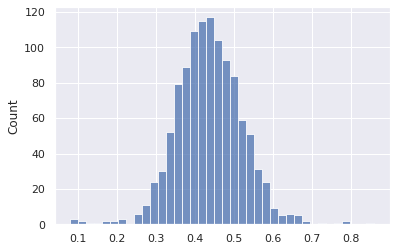

In [16]:
from scipy.stats import normaltest
sns.histplot(nuc_pct['1h_labeling_1h_wash'])
for sample in sample_list[:5]:
    print(normaltest(nuc_pct[sample]))

plot as grouped stacked bar

In [10]:
seg_pct = []
segs = ['nucleus', 'drp_10p', 'drp_10q']
for i, gene_cluster in enumerate([c1,c2,c3,c4]):
    for sample in sample_list[:5]:
        seg_cts = []
        for seg in segs:
            seg_ct = np.expand_dims(np.sum(adata_DRP[sample].layers[seg][:,np.isin(genes, gene_cluster)], axis=1), axis=1)
            seg_cts.append(seg_ct)
        ct = np.concatenate(seg_cts, axis=1)
        ct = ct[adata_DRP[sample].obs['KD_label_new']=='siControl']
        ct_norm = np.array([row/sum(row) for row in ct])
        ct_mean = np.mean(ct_norm, axis=0)
        seg_pct.extend(list(zip(ct_mean, segs, [sample]*len(segs), [i]*len(segs))))
df = pd.DataFrame(seg_pct, columns=['pct', 'sub_seg', 'time_point', 'cluster'])
df

,pct,sub_seg,time_point,cluster
0,0.560397,nucleus,1h_labeling,0
1,0.252164,drp_10p,1h_labeling,0
2,0.187439,drp_10q,1h_labeling,0
3,0.532472,nucleus,1h_labeling_1h_wash,0
4,0.259665,drp_10p,1h_labeling_1h_wash,0
5,0.207863,drp_10q,1h_labeling_1h_wash,0
6,0.488235,nucleus,1h_labeling_2h_wash,0
7,0.259961,drp_10p,1h_labeling_2h_wash,0
8,0.251805,drp_10q,1h_labeling_2h_wash,0
9,0.466237,nucleus,1h_labeling_4h_wash,0


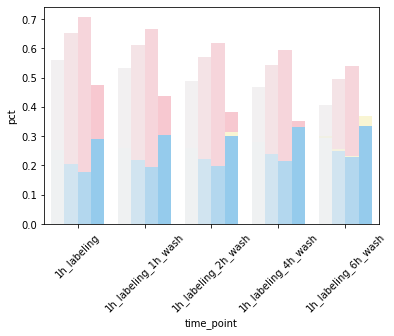

In [11]:
col = ['lightskyblue', 'lemonchiffon', 'pink']
for i, ss in enumerate(df.groupby('sub_seg')):
    sns.barplot(data=ss[1], x='time_point', y='pct', hue='cluster', zorder=-i, color=col[i]).legend_.remove()
    plt.xticks(rotation=45)

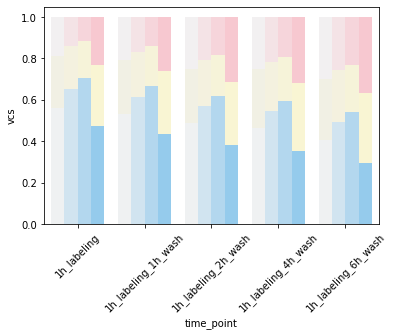

In [12]:
df.set_index(['cluster', 'time_point', 'sub_seg'], inplace=True)
df['vcs'] = df.groupby(level=('cluster', 'time_point')).cumsum()['pct']
df.reset_index(inplace=True)

col = ['lightskyblue', 'lemonchiffon', 'pink']

for i, ss in enumerate(df.groupby('sub_seg', sort=False)):
    sns.barplot(data=ss[1], x='time_point', y='vcs', hue='cluster', zorder=-i, color=col[i]).legend_.remove()
plt.xticks(rotation=45)
plt.savefig('bulk_cluster.pdf')

In [84]:
# plt.savefig('bulk_cluster.pdf')

<Figure size 432x288 with 0 Axes>